## CAM
#### Referrence: https://github.com/nickbiso/Keras-Class-Activation-Map

In [1]:
from keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from keras import backend as K
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()

### VGG16

In [2]:
model = VGG16(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


#### Sample Image

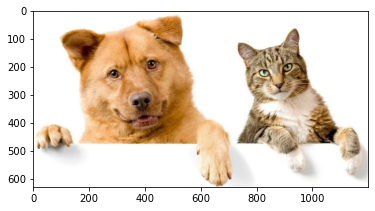

In [3]:
img_path = 'input/catdog3.jpg'
from PIL import Image
org_img = Image.open(img_path)
plt.imshow(org_img)

Resizing image to fit the input size of VGG

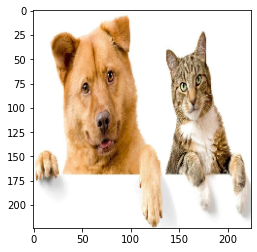

In [4]:
from keras.preprocessing import image
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

#### Convert to numpy array
#### Reshape data so that it is in "batch" form because the model only accepts input in this form

In [5]:
x = image.img_to_array(img)
import numpy as np
x = np.expand_dims(x, axis=0)

x.shape

(1, 224, 224, 3)

#### Preprocessing

In [6]:
from keras.applications.vgg16 import preprocess_input
x = preprocess_input(x)

#### Prediction

In [7]:
import pandas as pd
from keras.applications.vgg16 import decode_predictions
preds = model.predict(x)
predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
print('PREDICTION:', predictions.loc[0,'category'])

PREDICTION: collie


Text(0.5, 1.0, 'Top 3 Predictions:')

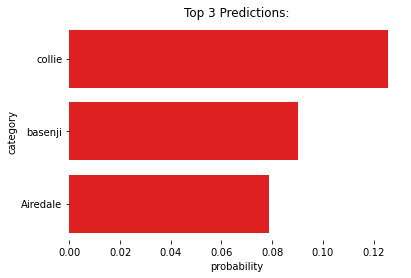

In [8]:
import seaborn as sns
f = sns.barplot(x='probability',y='category',data=predictions,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

In [9]:
argmax = np.argmax(preds[0])
output = model.output[:, argmax]
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Get the final Convolutional Layer
#### Get Gradient

In [10]:
# Get Gradient
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(output, last_conv_layer.output)[0]

# Each entry of this tensor is the mean intensity of the gradient over a specific feature map channel. 
# This has a shape of (512,)
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Access the values of the quantities we just defined
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
# "how important this channel is" with regard to the top class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

### Heatmap

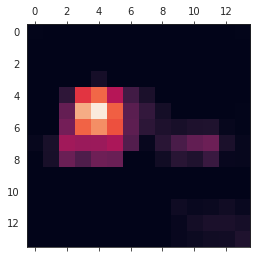

In [11]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [12]:
# import cv2
# img = cv2.imread(img_path)
# heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))


In [13]:
# from skimage.transform import resize
# import skimage
# img=mpimg.imread(img_path)
# img.shape
# # scipy.misc.imresize(heatmap, (img[0], img[1]))
# resize(heatmap, (img[0], img[1]))

In [15]:
from skimage.transform import resize
s = org_img.size
heatmap = resize(heatmap, (s[1], s[0]))
heatmap = np.uint8(255 * heatmap)

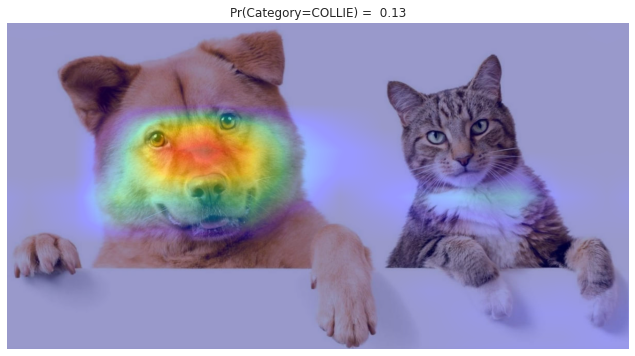

In [16]:
def plot_map(grads, im):
#     fig, axes = plt.subplots(1,2,figsize=(14,5))
    fig, ax = plt.subplots(figsize=(14,6))
    ax.imshow(im)
#     plt.imshow(im)
    i = ax.imshow(grads,cmap="jet",alpha=0.4)
#     fig.colorbar(i, ax=ax)
    plt.title("Pr(Category={}) = {:5.2f}".format(
                      predictions.loc[0,'category'].upper(),
                      predictions.loc[0,'probability']))
    plt.axis('off')
#     plt.savefig('foo.png')
plot_map(heatmap, org_img)

In [17]:
def cam(img_path):
    model = VGG16(weights='imagenet')
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    org_img = Image.open(img_path)
    size = org_img.size
    heatmap = resize(heatmap, (size[1], size[0]))
    heatmap = np.uint8(255 * heatmap)
    plot_map(heatmap, org_img)

    return None

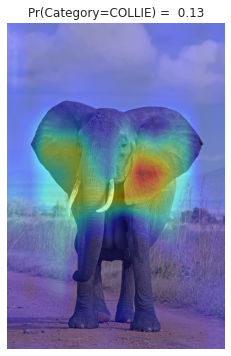

In [18]:
cam('input/elephant.jpg')

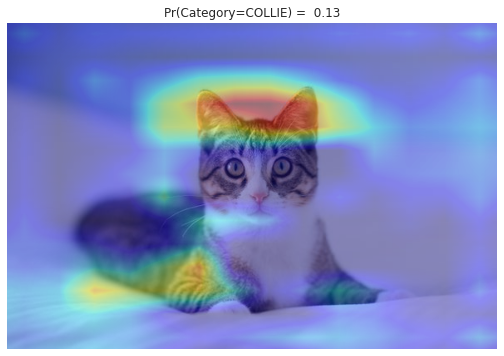

In [19]:
cam('input/cat1.jpg')